In [1]:
"""This is video reader with all operations inside fnctions, so they can be called on 
    each frame out of a set of frames, and each video out of a set of videos
    """

'This is video reader with all operations inside fnctions, so they can be called on \n    each frame out of a set of frames, and each video out of a set of videos\n    '

In [2]:
"""Imports"""
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from skimage import measure
from skimage.filters import threshold_yen, threshold_isodata
from operator import attrgetter
import numpy as np
import math
from itertools import chain
from glob import glob
#import antigravity

In [3]:
"""Functions"""
# read in a file, save the video sequence
def full_avi(filename):
    Vid = skvideo.io.vread(filename)

    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(Vid[0]) # first fame of video
    ax[1].imshow(Vid[-1]) #last frame of video

    print("Video shape is: ", Vid.shape)
    print("Video length is: ", len(Vid))
    
    return Vid

# take a read video; makeit a 2D matrix
def greens(framelist):
    green = framelist[:, :, :, 2]
    #print("This is the green channel of the image")
    #print("The slice shape is: ", green.shape)
    #plt.imshow(green[1], cmap='Greys_r')
    return green


# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, indes):
    # returns a new list, different from the orginal
    fll = len(framelist)
    f_indices = []
    f_ap = f_indices.append
    threshed_images = []
    t_ap = threshed_images.append
    m_lab = measure.label
    m_rop = measure.regionprops
    
    sides = {"bm":[], "b":[], "t":[], "ucf":[]}
    classes = {"bm":[], "br":[], "bl":[], "tr":[], "tl":[], "ucf":[], "newt":[]}
    
    for i in range(fll):
       # print("new_frame")
        frame = framelist[i]
        thresh_img = frame > threshold_yen(frame) # binary image
        img_labelled = m_lab(thresh_img) # contains connected regions
        properties_list = m_rop(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r = max(properties_list, key = attrgetter('area'))
        """ for k in range(len(properties_list)):
            if areas[k] > biggest_area:
                biggest_r = properties_list[k]
            else:
                pass"""

        #----------------------filter------------------------- can use actual filter
        area_threshold = 1800   # must have enough particles
        convex_thresholds = (2000, 2800)   # convex hull area (> 2500 filtered)  # particles must be in parallelogram
        minor_thresholds = (38, 48) # minor_axis length (< filterd) # particles must be in parallelogram
        major_thresholds = (59, 76)
        #inertia_thresholds = (355, 455)
        #ecc_threshold = .88
        test = (biggest_r.filled_area > area_threshold and
                #biggest_r.eccentricity < ecc_threshold and# must have enough particles
            biggest_r.minor_axis_length > minor_thresholds[0] # minor_axis length (< filterd) # particles must be in parallelogram
            and biggest_r.minor_axis_length < minor_thresholds[1]  # minor_axis length (< filterd) # particles must be in parallelogram
            and biggest_r.convex_area > convex_thresholds[0]  # convex hull area (> 2500 filtered)  # particles must be in parallelogram
            and biggest_r.convex_area < convex_thresholds[1]  # convex hull area (> 2500 filtered)  # particles must be in parallelogram
            and biggest_r.major_axis_length > major_thresholds[0]  # major_axis length (< filterd) # particles must be in parallelogram
            and biggest_r.major_axis_length < major_thresholds[1])  # major_axis length (< filterd) # particles must be in parallelogram
            #and biggest_r.inertia_tensor[0, 0] + biggest_r.inertia_tensor[1,1] > inertia_thresholds[0]  # major_axis length (< filterd) # particles must be in parallelogram
            #and biggest_r.inertia_tensor[0, 0] + biggest_r.inertia_tensor[1,1] < inertia_thresholds[1])
        
        if test: # keep frames that have enough paricles, and are not transitions
            f_ap(i) # image's index 
            i_threshed = frame > threshold_isodata(frame)
            img2_labelled = m_lab(i_threshed)
            properties2_list = m_rop(img2_labelled)
            biggest_r2 = max(properties2_list, key = attrgetter('area'))
            t_ap((img_labelled, img2_labelled))
            #-----------------------------classify pt 1---------------------------------------
            coprod = coord_prod(thresh_img, i_threshed)
            side = sideify(biggest_r2)
            clas = classify(side, -coprod)
            sides[side].append((frame, tf - indes[i]))
            classes[clas].append((frame, tf - indes[i]))
            
    filtrate = framelist[f_indices]
    return [[(filtrate[i], threshed_images[i], indes[i]) for i in range(len(filtrate))], sides, classes]



        
# take largest isodata image region, and return aclassification
def sideify(idir):
    iner = idir.inertia_tensor[0, 0] + idir.inertia_tensor[1, 1]
    maal = idir.major_axis_length
    mial = idir.minor_axis_length
    sol = idir.solidity 
    ecc = idir.eccentricity
    cva = idir.convex_area
    area = idir.area
    if area < 1470:
        return "ucf"
    elif ecc <= 0.79 and  maal > 65.5:
        return "bm"
    elif ecc > 0.81 and cva < 2140: #  and or (mial < 41 and maal > 65): # it's on top
        return "t"
    elif maal < 63: #or mial > 42  #and cva > 2200 and iner < 325: #or (maal < 64 and iner < 360): # it's on bottom
        return "b"
    else:
        return "ucf"

def classify(side, coprod):
    if side == "t":
        if coprod > 0:
            return "tl"
        else:
            return "tr"
    elif side == "b": 
        if coprod > 0:
            return "br"
        else:
            return "bl"
    elif side == "bm":
        return "bm"
    elif side == "ucf":
        return "ucf"
    else:
        return "newt"


def coord_prod(thresh_y, thresh_i):
    m_rop = measure.regionprops
    for i in range(0, 1):#len(fl):
        one_and_some = thresh_y ^ thresh_i
        full_rs_props = m_rop(measure.label(thresh_y))
        one_rs_props = m_rop(measure.label(one_and_some))
        biggest_full_props = max(full_rs_props, key = attrgetter('area'))
        biggest_one_props = max(one_rs_props, key = attrgetter('area'))
        full_com = biggest_full_props.centroid
        one_com = biggest_one_props.centroid
        orien = biggest_full_props.orientation
        #print(full_com, one_com, orien)
        
        rel_one_com = (one_com[0] - full_com[0], one_com[1] - full_com[1])
        oriented_rel_one_com = rotate_point(rel_one_com, -orien)
        product = oriented_rel_one_com[0]*oriented_rel_one_com[1]
        #print(rel_one_com, product)
        return product
        
    

def rotate_point(point, angle):
    x0 = point[0]
    y0 = point[1]
    x1 = x0*np.cos(angle) - y0*np.sin(angle)
    y1 = x0*np.sin(angle) + y0*np.cos(angle)
    return (x1, y1)

    """else:
        side = side(region)
        x, y = get_x,y
        if x * y > 0:
            if side == 'right':
                return 'tl'
            else:
                return 'br'
        else:
            if side == 'right':
                return 'tr'
            else:
                return 'bl'"""    
# if solidity <= .76 and inertia > 400 => bm
# elif inertia >=355 and mal >= 63 => tl/tr
# elif inertia <= 355 and mal <= 63 => bl/br
# else unclassifiable

        
#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot

#from two above measuremens, in larger function, take a frame and pair of thresholded images, and return the frame and the shape


Video shape is:  (1067, 256, 256, 3)
Video length is:  1067


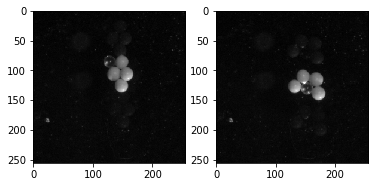

In [4]:
"""Pipeline for videos:"""
# initialize frame list
#filename2 = glob("./tchakamau/New_setup/unstable*.avi")[0]#"./tchakamau/New_setup/45701_10Vpp_18_tester.avi"
filename = glob("./tchakamau/New_setup/Multiple*.avi")[0]
frame_vid = full_avi(filename) # making videos ino a frame list
#frame_vid_2 = full_avi(filename2) # making videos ino a frame list
#-----------------------------------------------------------------------



(1067, 256, 256, 3)


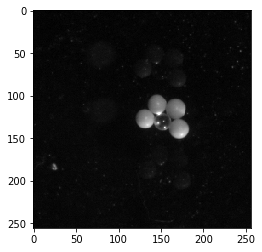

In [5]:
framelist = frame_vid#np.concatenate((frame_vid, frame_vid_2))#np.concatenate((frame_vid[l], frame_vid_2[l2]))# will be replaced by full video
plt.imshow(framelist[-1])
print(framelist.shape)

In [6]:
"""Pipeline for lists of frames"""
"""And test thereof (using isinar)"""
def piped(framelist, h):
    # key variable to be passed into the function is framelist
    green_frames = greens(framelist) # making a green slice
    filtered_frames = total_threshold_filter(green_frames, h)
    return filtered_frames

def isinar(a, als):
    #print(a)
    y = False
    for ele in als:
        #print(ele)
        y = np.array_equal(ele, a)
        if y:
            return y
        else: 
            continue
    return y

org = piped(framelist, range(len(framelist)))
twf = org[0]
sids = org[1]
cls = org[2]
print("unfiltered ", len(framelist))
print("filtered ", len(twf))
print("length of sides ", len([x for y in sids.values() for x in y]))
print("length of classes ", len([x for y in cls.values() for x in y]))
filts = [j[ :, :, 2] for j in framelist if not isinar(j[:, :, 2], [k[0] for k in twf] )] #jnot in [k[0] for k in twf]]
print("length of filtered out slides ", len(filts))

print("length of side classifs ", [[x, len(sids[x])] for x in sids])
print("lengths of each classes classif ", [[x, len(cls[x])] for x in cls])

C:\ProgramData\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


NameError: name 'tf' is not defined

In [ ]:
"""Visualizethe classifiedobjects"""
for key in sids.keys():
    vals = sids[key]
    frames = [val[0] for val in vals]
    c = 5
    r = len(vals)// c
    for j in range(r):
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(frame)
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(frame > threshold_isodata(frame))
    
    

In [ ]:
"""Visualizethe classifiedobjects"""
for key in cls.keys():
    vals = cls[key]
    frames = [val[0] for val in vals]
    c = 5
    r = len(vals)// c
    for j in range(r):
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(frame)
        fig, ax = plt.subplots(ncols=c, figsize = (14, 10))
        for k in range(c):
            frame = frames[j * c + k]
            ax[k].set_title(key)
            ax[k].imshow(frame > threshold_isodata(frame))

In [ ]:
frams = framelist
filtered_len = len(twf)

print("unfiltered ", len(frams))
print("filtered ", filtered_len)
#filts = [j[ :, :, 2] for j in framelist if not isinar(j[:, :, 2], [k[0] for k in twf] )] #jnot in [k[0] for k in twf]]
#print("length of filtered out slides ", len(filts))
skeys = list(sids.keys())
print ('skeys', skeys)
ckeys = list(cls.keys())
print ('ckeys', ckeys)
slcs = [len(sids[x]) for x in skeys]
clcs = [len(cls[x]) for x in ckeys]
ucf = len(sids["ucf"])
newtucf = len(cls["newt"]) + ucf
print(slcs, clcs)
print("length of side classifs ", [[skeys[i], slcs[i], '%.2f' %(slcs[i] *100/ filtered_len)] for i in range(len(skeys))])
print("lengths of each classes classif ", [[ckeys[i], clcs[i], "%.2f" %(clcs[i] *100/ filtered_len)] for i in range(len(ckeys))])